# Code Executors
![alt text](image/image-1.png)

AutoGen에서 **Code Executors**는 코드 블록을 포함한 입력 메시지를 받아 실행하고, 그 결과를 메시지로 출력하는 구성 요소 

AutoGen은 두 가지 내장 코드 실행기를 제공. 

하나는 UNIX 셸과 같은 커맨드 라인 환경에서 코드를 실행하는 **커맨드 라인 코드 실행기**이고, 

다른 하나는 Jupyter 커널에서 코드를 실행하는 **Jupyter 실행기**.

각 실행기 유형에 대해 AutoGen은 두 가지 방식으로 코드를 실행할 수 있다:  


1. **로컬 실행:** AutoGen이 실행되고 있는 동일한 호스트 플랫폼, 즉 로컬 운영 체제에서 직접 코드를 실행 

이 방식은 개발 및 테스트에 적합하지만, LLM이 임의의 코드를 생성할 수 있으므로 프로덕션 환경에서는 이상적이지 않습니다.


2. **Docker 컨테이너 실행:** Docker 컨테이너 내에서 코드를 실행

아래 표는 코드 실행기와 실행 환경의 조합

| Code Executor (autogen.coding)          | Environment                   | Platform         |
|-----------------------------------------|-------------------------------|------------------|
| LocalCommandLineCodeExecutor            | Shell                         | Local            |
| DockerCommandLineCodeExecutor           | Shell                         | Docker           |
| jupyter.JupyterCodeExecutor             | Jupyter Kernel (예: python3)  | Local/Docker     |

>
> **주의**  
> LLM이 생성한 코드를 실행하는 것은 호스트 환경에 보안 위험을 초래할 수 있다고 하네요~


코드 블록이 포함된 메시지를 수신하면, 로컬 커맨드 라인 코드 실행기는 먼저 해당 코드 블록을 코드 파일로 작성한 후, 새로운 서브프로세스를 시작하여 코드 파일을 실행한다. 실행기는 코드 실행의 콘솔 출력을 읽어 응답 메시지로 다시 전송한다.


In [10]:
import tempfile

from autogen import ConversableAgent
from autogen.coding import LocalCommandLineCodeExecutor

# Create a temporary directory to store the code files.
temp_dir = tempfile.TemporaryDirectory()

# Create a local command line code executor.
executor = LocalCommandLineCodeExecutor(
    timeout=10,  # Timeout for each code execution in seconds.
    work_dir=temp_dir.name,  # Use the temporary directory to store the code files.
)

# Create an agent with code executor configuration.
code_executor_agent = ConversableAgent(
    "code_executor_agent",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={"executor": executor},  # Use the local command line code executor.
    human_input_mode="ALWAYS",  # Always take human input for this agent for safety.
)

In [2]:
! pip install -qqq matplotlib numpy

In [3]:
message_with_code_block = """This is a message with code block.
The code block is below:
```python
import numpy as np
import matplotlib.pyplot as plt
x = np.random.randint(0, 100, 100)
y = np.random.randint(0, 100, 100)
plt.scatter(x, y)
plt.savefig('scatter.png')
print('Scatter plot saved to scatter.png')
```
This is the end of the message.
"""

# Generate a reply for the given code.
reply = code_executor_agent.generate_reply(messages=[{"role": "user", "content": message_with_code_block}])
print(reply)


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
exitcode: 0 (execution succeeded)
Code output: Scatter plot saved to scatter.png



In [9]:
import os

print(os.listdir(temp_dir.name))
# We can see the output scatter.png and the code file generated by the agent.

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpc8vx7yzg'

In [5]:
temp_dir.cleanup()

# 대화에서 코드 실행 사용
![alt text](image/image-2.png)

데이터 분석, 머신러닝, 수학적 모델링 등 많은 작업에서 코드를 작성하고 실행하는 것은 필수적이다. 

AutoGen에서는 코드 작성을 위한 에이전트와 코드 실행을 담당하는 에이전트 간의 대화를 통해, 

개발자와 코드 인터프리터 간의 상호작용을 모방할 수 있다!!

## 코드 작성자와 코드 실행자

- **코드 작성자 에이전트:**  
  GPT-4와 같이 코드 작성 능력을 갖춘 LLM이 코드 작성
  
- **코드 실행 에이전트:**  
  코드 실행기를 사용하여 작성된 코드를 실제로 실행


In [15]:
# The code writer agent's system message is to instruct the LLM on how to use
# the code executor in the code executor agent.
code_writer_system_message = """You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feedback or perform any other action beyond executing the code you suggest. The user can't modify your code. So do not suggest incomplete code which requires users to modify. Don't use a code block if it's not intended to be executed by the user.
If you want the user to save the code in a file before executing it, put # filename: <filename> inside the code block as the first line. Don't include multiple code blocks in one response. Do not ask users to copy and paste the result. Instead, use 'print' function for the output when relevant. Check the execution result returned by the user.
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
When you find an answer, verify the answer carefully. Include verifiable evidence in your response if possible.
Reply 'TERMINATE' in the end when everything is done.
"""

code_writer_agent = ConversableAgent(
    "code_writer_agent",
    system_message=code_writer_system_message,
    llm_config={"config_list": [{"model": "gpt-4", "api_key": os.environ["OPENAI_API_KEY"]}]},
    code_execution_config=False,  # Turn off code execution for this agent.
)

In [16]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message="Write Python code to calculate the 14th Fibonacci number.",
)

code_executor_agent (to code_writer_agent):

Write Python code to calculate the 14th Fibonacci number.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...


KeyboardInterrupt: 

In [17]:
import datetime

today = datetime.datetime.now().strftime("%Y-%m-%d")
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=f"Today is {today}. Write Python code to plot TSLA's and META's "
    "stock price gains YTD, and save the plot to a file named 'stock_gains.png'.",
)

code_executor_agent (to code_writer_agent):

Today is 2025-02-17. Write Python code to plot TSLA's and META's stock price gains YTD, and save the plot to a file named 'stock_gains.png'.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer_agent (to code_executor_agent):

Sure, to achieve this, we can use the `yfinance` library in python. It allows us to download historical stock market data. 

Here is the plan:
1. With the use of yfinance library we will download the historical stock market data of TSLA and META starting from the first day of this year i.e. 2025-01-01 to the current date which is 2025-02-17.
2. Then with the use of Matplotlib library we will plot a line graph where on the x-axis we will have the Date and on the y axis we will have the close price. Plot will include the stock data comparison for both META and TSLA.
3. Then save the plot to a file name 'stock_gains.png'.

Please execute the following 

['plot_stock.py', 'tmp_code_7a766f6a281ce33caf4155a2200f731d.shell', 'tmp_code_c2b0b6894fb4138b8f42a000b17d70a4.shell', 'plot_stock_reduced_data.py', 'Calculate the 14th Fibonacci number', 'stock_gains.png']


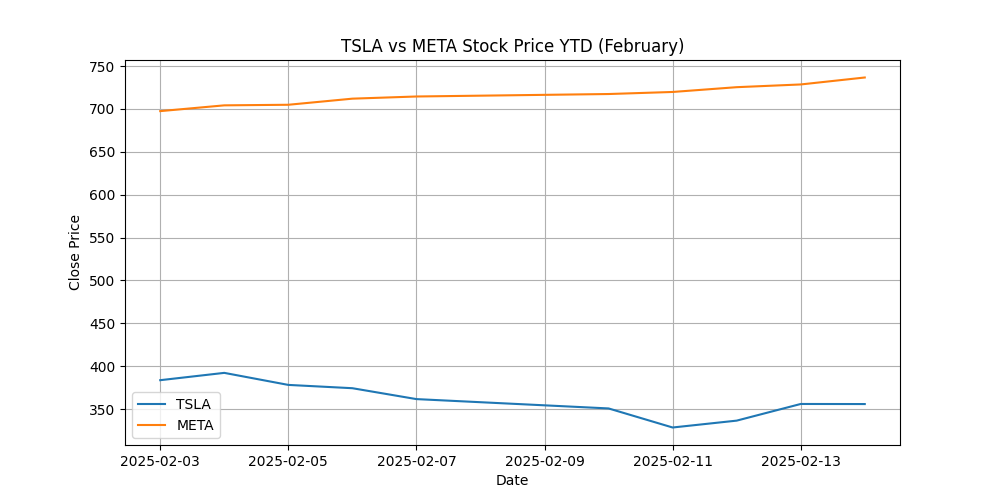

In [23]:
from IPython.display import Image


print(os.listdir(temp_dir.name))
Image(os.path.join(temp_dir.name, "stock_gains.png"))

In [ ]:
temp_dir.cleanup()

In [24]:
import pprint

from autogen import AssistantAgent

pprint.pprint(AssistantAgent.DEFAULT_SYSTEM_MESSAGE)

('You are a helpful AI assistant.\n'
 'Solve tasks using your coding and language skills.\n'
 'In the following cases, suggest python code (in a python coding block) or '
 'shell script (in a sh coding block) for the user to execute.\n'
 '    1. When you need to collect info, use the code to output the info you '
 'need, for example, browse or search the web, download/read a file, print the '
 'content of a webpage or a file, get the current date/time, check the '
 'operating system. After sufficient info is printed and the task is ready to '
 'be solved based on your language skill, you can solve the task by yourself.\n'
 '    2. When you need to perform some task with code, use the code to perform '
 'the task and output the result. Finish the task smartly.\n'
 'Solve the task step by step if you need to. If a plan is not provided, '
 'explain your plan first. Be clear which step uses code, and which step uses '
 'your language skill.\n'
 'When using code, you must indicate the scrip